In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from tqdm import tqdm
import scipy.optimize
import seaborn as sns

import frame_whitening as fw
import frame_whitening.simulation as fws

In [182]:
def simulate_one(n, eta_g, n_batch, frame, seed=0):
    assert frame in ["GRASSMANN", "RANDN"]
    np.random.seed(seed)
    # setup
    k = n * (n + 1) // 2
    V, _ = np.linalg.qr(np.random.randn(n, n))
    s = (np.linspace(1, 5, n) + np.random.randn(n) * 0.1) * 10
    Cxx = V @ np.diag(s) @ V.T
    Lxx = np.linalg.cholesky(Cxx)
    kappa0 = np.linalg.cond(Cxx)
    if frame == "GRASSMANN":
        # W, G, res = fw.get_grassmannian(n, k, niter=1000)
        W, _ = fw.get_grassmannian(n, k)
    else: # frame == "RANDN":
        W = np.random.randn(n, k)
    W = fw.normalize_frame(W)

    g_last, g_all, errors, variances = fws.simulate([Lxx], W, 0, n_batch, eta_g, None, False, False) 

    return errors

def simulate_many(n_repeats, frame):
    with multiprocessing.Pool() as pool:
        all_errors = []
        pbar = tqdm(total=n_repeats)
        for errors in pool.starmap(simulate_one, [(3, 1E-1, 5000, frame, i) for i in range(n_repeats)]):
            all_errors.append(errors)
            pbar.update(1)
    all_errors = np.array(all_errors)
    return all_errors

In [183]:
n_repeats = 200
all_errors_randn = simulate_many(n_repeats, "RANDN")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.75it/s]


In [184]:
all_errors_grassmann = simulate_many(n_repeats, "GRASSMANN")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 59.42it/s]


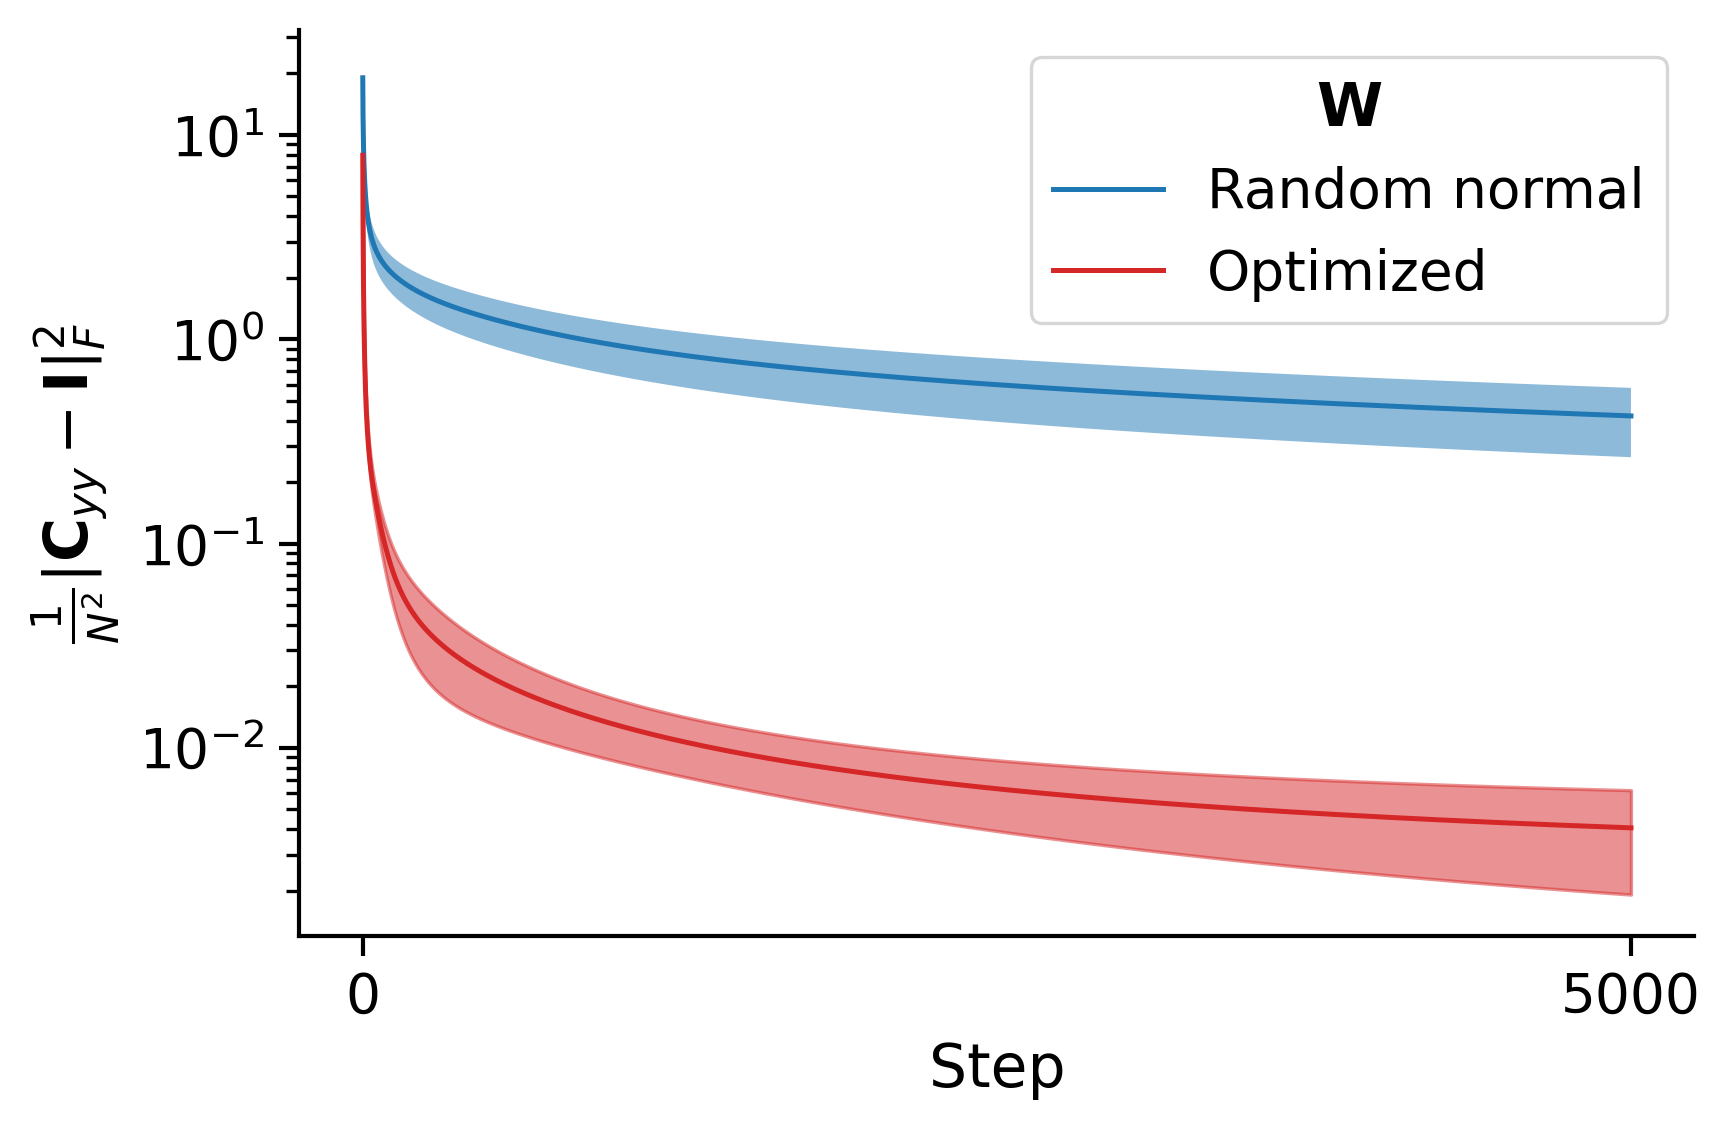

In [186]:
# fmt: off

def get_mean_sem(x):
    return np.mean(x, axis=0), np.std(x, axis=0) / np.sqrt(x.shape[0])

with sns.plotting_context("paper", font_scale=1.5):
    fig, ax = plt.subplots(1, 1, dpi=300)

    mu_randn, sig_randn = get_mean_sem(all_errors_randn)
    mu_opt, sig_opt = get_mean_sem(all_errors_grassmann)

    ax.plot(range(len(mu_randn)), mu_randn, color="C0", label="Random normal")
    ax.fill_between(range(len(mu_randn)), mu_randn - sig_randn, mu_randn + sig_randn, alpha=0.5)

    ax.plot(range(len(mu_opt)), mu_opt, color="C3", label="Optimized")
    ax.fill_between(range(len(mu_opt)), mu_opt - sig_opt, mu_opt + sig_opt, color="C3", alpha=0.5)

    ax.set(yscale="log", ylabel=r"$\frac{1}{N^2}\|{\bf C}_{yy} - {\bf I}\|_F^2$", 
    xlabel="Step", xticks=(0, 5000))

    ax.legend(title=r"${\bf W}$")

    sns.despine()
# fmt: on